In [602]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import sklearn.metrics
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

**Data Preprocessing**


In [604]:
def wrangle(filepath):
    df = pd.read_csv(filepath)

    # Selecting relevant columns
    df = df[["Order Date", "Sales"]]

    # Converting "Order Date" column to datetime
    df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")

    # Setting index to "Order Date"
    df = df.set_index("Order Date")

    #Removing Outliers
     # Compute Q1 (25th percentile) and Q3 (75th percentile)
    low = df["Sales"].quantile(0.25)
    high = df["Sales"].quantile(0.75)

     # Compute IQR
    IQR = high - low

     # Define outlier thresholds
    lower_bound = low - 1.5 * IQR
    upper_bound = high + 1.5 * IQR

     # Filter out outliers
    df = df[(df["Sales"] >= lower_bound) & (df["Sales"] <= upper_bound)]

    #Resampling to 1M window
    df=df["Sales"].resample("1M").mean().to_frame()

    #Creating a lag feature
    df["Sales.L1"]= df["Sales"].shift(1)
    df.dropna(inplace=True)

    return df


In [605]:
df = wrangle("C:/Users/Administrator/Documents/Future Interns/stores_sales_forecasting.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47 entries, 2014-02-28 to 2017-12-31
Freq: ME
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sales     47 non-null     float64
 1   Sales.L1  47 non-null     float64
dtypes: float64(2)
memory usage: 1.1 KB


In [606]:
df.head()


,Sales,Sales.L1
Order Date,,
2014-02-28,97.239667,144.486944
2014-03-31,269.413926,97.239667
2014-04-30,218.411542,269.413926
2014-05-31,247.818565,218.411542
2014-06-30,262.627562,247.818565


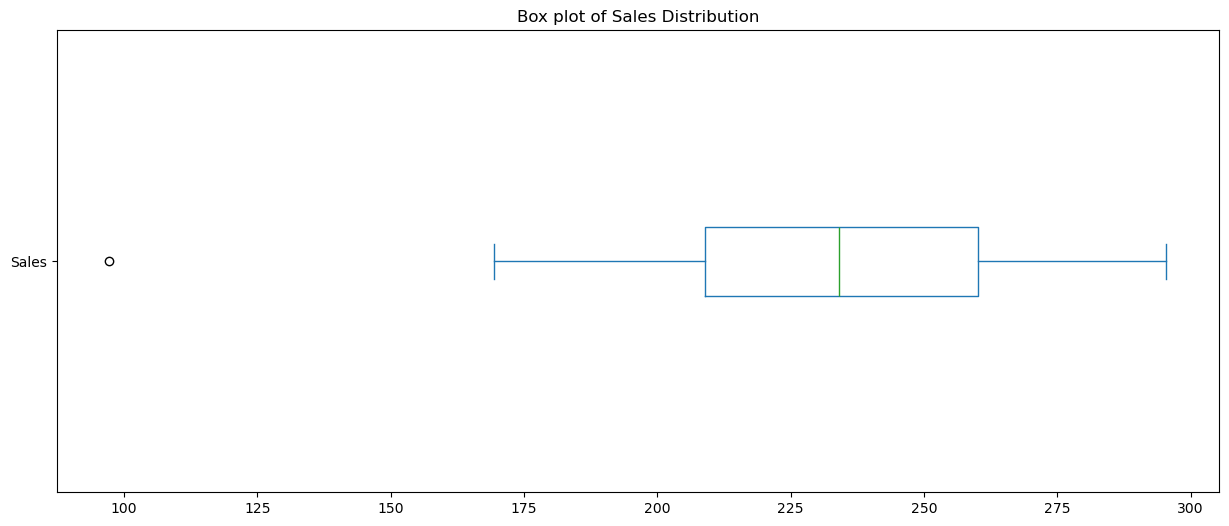

In [607]:
#Plotting a box plot to identify outliers
fig, ax= plt.subplots(figsize= (15,6))
df["Sales"].plot(kind= "box",vert= False, title="Box plot of Sales Distribution", ax=ax);



In [608]:
#Dropping the values below the lower bound
df = df[df.index != "2014-02-28"]
print(df["Sales"].head())


Order Date
2014-03-31    269.413926
2014-04-30    218.411542
2014-05-31    247.818565
2014-06-30    262.627562
2014-07-31    295.412844
Freq: ME, Name: Sales, dtype: float64


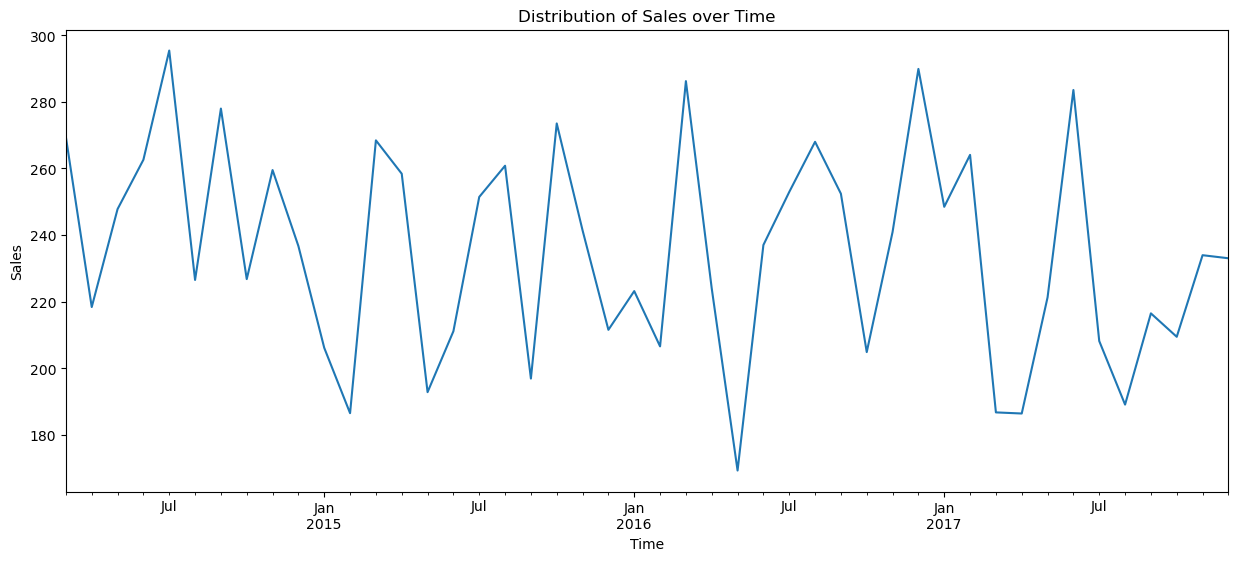

In [609]:
#Time Series Plot
fig, ax= plt.subplots(figsize=(15,6))
df["Sales"].plot(xlabel="Time", ylabel= "Sales", title="Distribution of Sales over Time",ax=ax);

In [610]:
#Checking for stationarity in the data
result = adfuller(df["Sales"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")  # If p-value > 0.05, the data is non-stationary


ADF Statistic: -5.743874073319826
p-value: 6.185626606683761e-07


**Time Series Modelling**

In [612]:
#Splitting
target= "Sales"
y= df[target]
X= df.drop(columns=target)

In [613]:
#Dividing the data into training and testing sets
cutoff= int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

len (X_train) + len (X_test) == len (X)

True

In [614]:
#Building a model
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len (y_train)
mae_baseline =  mean_absolute_error(y_train, y_pred_baseline)
print(f"Mean Sales Reading :{y_mean.round(2)}")
print (f"Baseline MAE: {mae_baseline.round(2)}")

Mean Sales Reading :240.24
Baseline MAE: 25.84


**Forecasting Techniques**

*Model fitting and Evaluation*

In [617]:
# Prepare Data for Prophet
df_prophet = df.reset_index().rename(columns={"Order Date": "ds", "Sales": "y"})

# Train Prophet Model
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Create Future Dataframe for Forecasting
future = model_prophet.make_future_dataframe(periods=len(y_test), freq='M')
forecast_prophet = model_prophet.predict(future)

# Extract Forecasted Values
forecast_values = forecast_prophet["yhat"].iloc[-len(y_test):]

# Evaluate Performance
from sklearn.metrics import mean_absolute_error
test_mae_prophet = mean_absolute_error(y_test, forecast_values)
print(f"Test MAE with Prophet: {test_mae_prophet.round(2)}")


21:37:23 - cmdstanpy - INFO - Chain [1] start processing
21:37:23 - cmdstanpy - INFO - Chain [1] done processing


Test MAE with Prophet: 23.86


**Export data from python**

In [619]:
#Converting Historical Sales Data to CSV
df.to_csv("C:/Users/Administrator/Documents/Future Interns/Task 2/cleaned_sales_data.csv")


In [620]:
forecast_df = pd.DataFrame({
    "Order Date": y_test.index,
    "Actual Sales": y_test.values,
    "Prophet Forecast": forecast_values.values  # From Prophet model
})

forecast_df.to_csv("C:/Users/Administrator/Documents/Future Interns/Task 2/sales_forecast_results.csv", index=False)
